# Computer vision
It is the art of teaching a computer to see

#### What we are going to cover

<img src="img/04-computer-vision.png" alt="drawing" width="1000"/>

### important computer vision libraries
![img1](img/04-libraries.png)

In [85]:
import torch
from torch import nn
from torch.utils.data import DataLoader

# Computer vision libraries
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# for model evaluation
from torchmetrics import F1Score, Accuracy, ConfusionMatrix

# for visualization
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import plot_confusion_matrix

# for analysis
import pandas as pd

# for time measuring
from timeit import default_timer as timer

# for progress bar
from tqdm.auto import tqdm

# for model saving & loading
from pathlib import Path

# agnostic code
device = "cuda:0" if torch.cuda.is_available() else "cpu"

print(f'Current device is {device}')
print('PyTorch version is', torch.__version__)
print('torchvision version is', torchvision.__version__)

Current device is cpu
PyTorch version is 1.12.1+cu102
torchvision version is 0.13.1+cu102


In [2]:
def print_train_time(start, end, device):
     """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
     total_number = end - start
     print(f"Train time on {device} is {total_number:.3f} seconds")
     return total_number

In [3]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               score_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        score_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, score = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_predicted = model(X)
            y_predicted_labels = y_predicted.argmax(dim=1)
            loss += loss_fn(y_predicted, y)
            score += score_fn(y_predicted_labels, y)
        loss /= len(data_loader)
        score /= len(data_loader)
    d = {'model_name': model.__class__.__name__,
         'model_loss': loss.item(),
         'model_score': score.item()}
    return d

# 1. Dataset

In [4]:
train_data = datasets.FashionMNIST(root='data',
                                   train=True,
                                   transform=ToTensor(),
                                   target_transform=None)

test_data = datasets.FashionMNIST(root='data',
                                  train=False,
                                  transform=ToTensor())

print(f'train: {train_data}\n\ntest: {test_data}')

train: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

test: Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [5]:
type(train_data)

torchvision.datasets.mnist.FashionMNIST

In [6]:
# see example
print(f'type of element is {type(train_data[15])}')
print(f'feature shape is {train_data[15][0].shape}')
print(f'label {train_data[15][1]}')

type of element is <class 'tuple'>
feature shape is torch.Size([1, 28, 28])
label 9


**color_channels = 1, height = 28, weight = 28**

![img2](img/04-input-output-shapes.png)

PyTorch generally accepts `NCHW` format (channels first) as the default. But `NHWC` format (channels last) performs **better** and it is considered as **the best practice**

In [7]:
print('classes:', train_data.classes)

classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


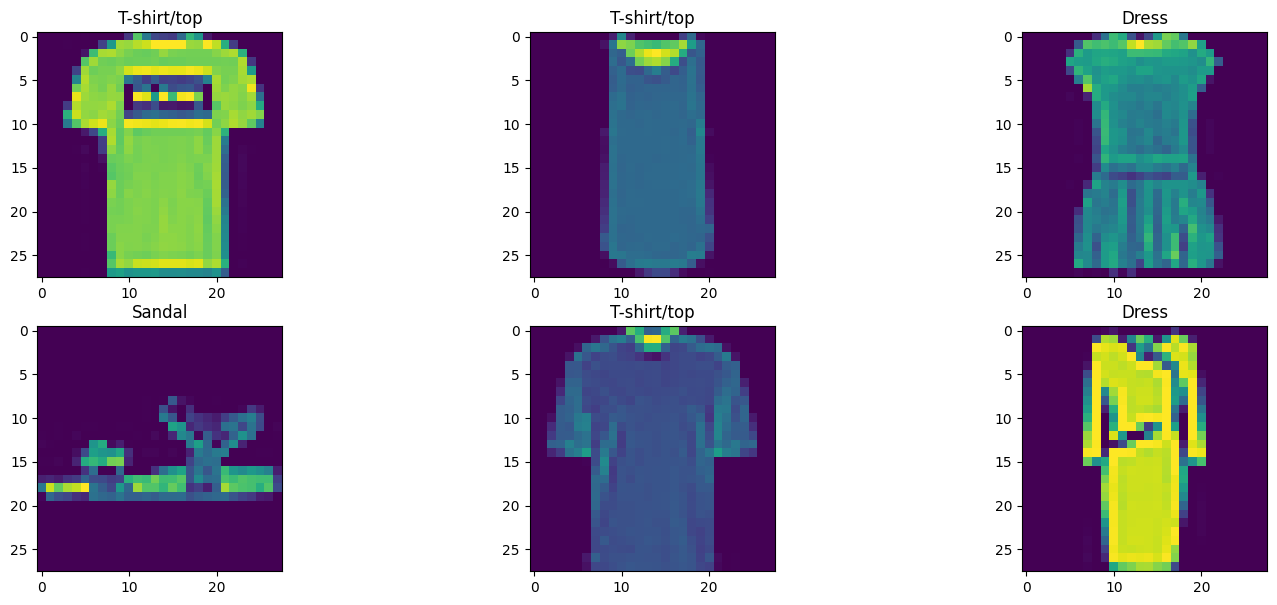

In [8]:
plt.figure(figsize=(18, 7))
for i in range(1, 4):
    image, label = train_data[i]
    plt.subplot(2, 3, i)
    plt.imshow(image.squeeze())
    plt.title(train_data.classes[label])

    image, label = train_data[-i]
    plt.subplot(2, 3, i+3)
    plt.imshow(image.squeeze())
    plt.title(train_data.classes[label])

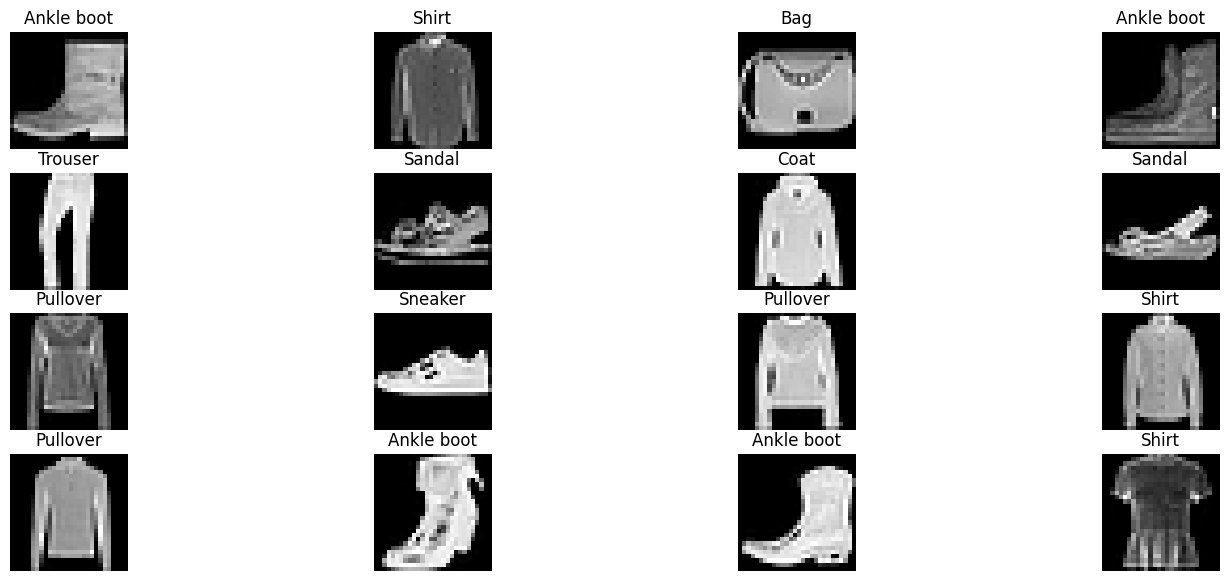

In [9]:
torch.manual_seed(42)
fig = plt.figure(figsize=(18, 7))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_index = torch.randint(low=0,
                                 high=len(train_data),
                                 size=[1]).item()
    image, label = train_data[random_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis(False)

# 2. Prepare Dataset
`DataLoader` helps load data into a model. It turns `Dataset` into iterable of chunks that are called **batches**. It's more efficient to use batches (really large datasets contain a lot of objects so it important to break data into batches)

In [10]:
# it is hyperparameter (32, 64, 128, 256, 512, ...)
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)

test_dataloader = DataLoader(dataset=test_data,
                              shuffle=False,
                              batch_size=BATCH_SIZE)

print(f'Dataloaders:\n'
      f'-train: {len(train_dataloader)} batches\n'
      f'-test: {len(test_dataloader)} batches')
print(f'Each batch contains {BATCH_SIZE} objects')

Dataloaders:
-train: 1875 batches
-test: 313 batches
Each batch contains 32 objects


In [11]:
# let see on the batch
example_features, example_labels = next(iter(train_dataloader))
print(example_features.shape, example_labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


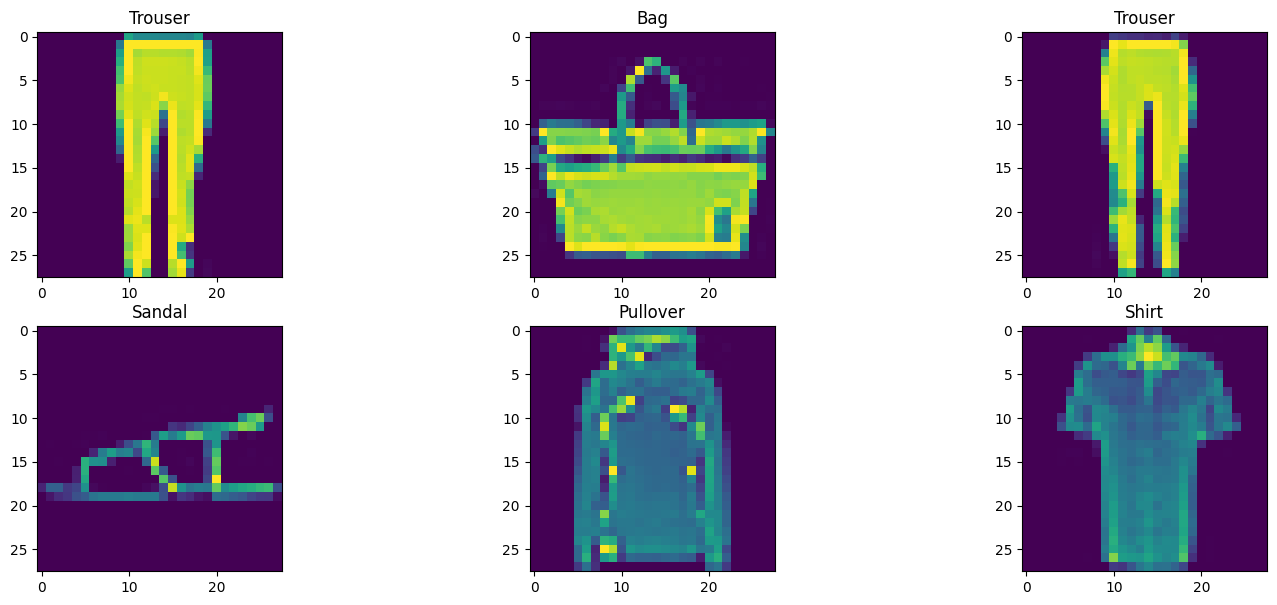

In [12]:
torch.manual_seed(0)
rows = 2
cols = 3
fig = plt.figure(figsize=(18, 7))
for i in range(1, rows*cols + 1):
    image = example_features[i]
    label = example_labels[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze())
    plt.title(train_data.classes[label])

# 3. Baseline model

In [13]:
class FashionModelV0(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Flatten(), # network prefer data in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units,   out_features=output_shape)
        )

    def forward(self, x):
        return self.layers_stack(x)

In [14]:
model_v0 = FashionModelV0(
    input_shape=1*28*28, # image (features) shape
    output_shape=10, # classes
    hidden_units=100,
    ).to(device=device)
model_v0

FashionModelV0(
  (layers_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [15]:
# check an output
model_v0(train_dataloader.dataset[0][0]).shape

torch.Size([1, 10])

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v0.parameters(),
                             lr=0.1)
f1_metric = F1Score(num_classes=10)
accuracy_metric = Accuracy(num_classes=10)

#### How our model will train?
1. Loop through epochs (each epoch model run the whole train data)
2. Loop through training batches
    2.1 calculate train loss per batch
    2.2 optimizer step per batch
3. Loop through testing batches
    2.1 calculate test loss per batch
    2.2 calculate metric per batch
4. Print what's happening each `n`th epoch
5. TIme it (fun)

In [17]:
torch.manual_seed(42)
train_time_start = timer()
epochs = 3

for epoch in tqdm(range(1, epochs+1)):
    print(f'Epoch {epoch} / {epochs} ----------')

    train_loss_epoch = 0
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        model_v0.train()
        y_pred = model_v0(X_train)
        train_loss_batch = loss_fn(y_pred, y_train)
        train_loss_epoch += train_loss_batch

        optimizer.zero_grad()
        train_loss_batch.backward()
        optimizer.step()

        if batch % 500 == 0:
            print(f'we saw {batch * len(X_train)}/{len(train_dataloader.dataset)} samples')

    # average
    train_loss_epoch = train_loss_epoch / len(train_dataloader)

    test_loss_epoch, score_test_epoch = 0.0, 0.0
    model_v0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            y_pred = model_v0(X_test)
            y_pred_labels = y_pred.argmax(dim=1)
            loss_test_batch = loss_fn(y_pred, y_test)
            score_test_batch = f1_metric(y_test, y_pred_labels)
            test_loss_epoch += loss_test_batch
            score_test_epoch += score_test_batch

        test_loss_epoch /= len(test_dataloader)
        score_test_epoch /= len(test_dataloader)

    print(f'Train loss: {train_loss_epoch:.5f}\n'
          f'Test loss: {test_loss_epoch:.5f}\n'
          f'Test F1-score: {score_test_epoch:.5f}')
train_time_end = timer()
total_time_v0 = print_train_time(start=train_time_start,
                                 end=train_time_end,
                                  device=str(next(model_v0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 / 3 ----------
we saw 0/60000 samples
we saw 16000/60000 samples
we saw 32000/60000 samples
we saw 48000/60000 samples
Train loss: 0.57824
Test loss: 0.50153
Test F1-score: 0.82608
Epoch 2 / 3 ----------
we saw 0/60000 samples
we saw 16000/60000 samples
we saw 32000/60000 samples
we saw 48000/60000 samples
Train loss: 0.47438
Test loss: 0.48306
Test F1-score: 0.83037
Epoch 3 / 3 ----------
we saw 0/60000 samples
we saw 16000/60000 samples
we saw 32000/60000 samples
we saw 48000/60000 samples
Train loss: 0.45395
Test loss: 0.47753
Test F1-score: 0.83466
Train time on cpu is 16.388 seconds


In [18]:
results_v0 = eval_model(model=model_v0,
                        data_loader=test_dataloader,
                        loss_fn=loss_fn,
                        score_fn=accuracy_metric)
results_v0

{'model_name': 'FashionModelV0',
 'model_loss': 0.4775281846523285,
 'model_score': 0.834664523601532}

# 4. Build a better model with non-linearity

In [19]:
class FashionModelV1(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100,
                      out_features=50),
            nn.Softplus(),
            nn.Linear(in_features=50,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.layers_stack(x)

In [20]:
model_v1 = FashionModelV1(input_shape=1*28*28,
                          output_shape=10).to(device=device)

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_v1.parameters(),
                             lr=0.01)

In [22]:
def train_epoch(model, train_loader, loss_function, eval_function, dev=device):
    loss_train_epoch, score_train_epoch = 0, 0
    for b, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(dev), y_batch.to(dev)
        model.train()

        y_predicted_logits = model(X_batch)
        y_predicted_targets = y_predicted_logits.argmax(dim=1)

        loss_train = loss_function(y_predicted_logits, y_batch)
        score_train = eval_function(y_predicted_targets, y_batch)

        loss_train_epoch += loss_train
        score_train_epoch += score_train

        optimizer.zero_grad()

        loss_train.backward()

        optimizer.step()

    loss_train_epoch /= len(train_loader)
    score_train_epoch /= len(train_loader)
    print('Train set:\n'
          f'* loss = {loss_train_epoch}\n'
          f'* Score = {score_train_epoch}')

In [23]:
def test_epoch(model, test_loader, loss_function, eval_function, dev=device):
    loss_test_epoch, score_test_epoch = 0, 0
    model.eval()
    with torch.inference_mode():
        for b, (X_batch, y_batch) in enumerate(test_loader):
            X_batch, y_batch = X_batch.to(dev), y_batch.to(dev)
            y_predicted_logits = model(X_batch)
            y_predicted_targets = y_predicted_logits.argmax(dim=1)
            loss_test = loss_function(y_predicted_logits, y_batch)
            score_test = eval_function(y_predicted_targets, y_batch)
            loss_test_epoch += loss_test
            score_test_epoch += score_test

        loss_test_epoch /= len(test_loader)
        score_test_epoch /= len(test_loader)
        print('Test set:\n'
             f'* loss = {loss_test_epoch}\n'
             f'* Score = {score_test_epoch}')

In [24]:
train_time_start = timer()

epochs = 3
for epoch in tqdm(range(1, epochs+1)):
    print(f'Epoch {epoch} / {epochs}')
    train_epoch(model=model_v1,
                train_loader=train_dataloader,
                loss_function=loss_fn,
                eval_function=f1_metric)
    test_epoch(model=model_v1,
               test_loader=test_dataloader,
               loss_function=loss_fn,
               eval_function=f1_metric)
train_time_end = timer()
total_time_v1 = print_train_time(start=train_time_start,
                                 end=train_time_end,
                                 device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 / 3
Train set:
* loss = 0.5248493552207947
* Score = 0.8105666637420654
Test set:
* loss = 0.49826809763908386
* Score = 0.8220846652984619
Epoch 2 / 3
Train set:
* loss = 0.4335266649723053
* Score = 0.8456000089645386
Test set:
* loss = 0.4374934732913971
* Score = 0.8490415215492249
Epoch 3 / 3
Train set:
* loss = 0.41110649704933167
* Score = 0.8563500046730042
Test set:
* loss = 0.45351430773735046
* Score = 0.8452476263046265
Train time on cpu is 23.047 seconds


In [25]:
results_v1 = eval_model(model=model_v1,
                        data_loader=test_dataloader,
                        loss_fn=loss_fn,
                        score_fn=accuracy_metric)
results_v1, results_v0

({'model_name': 'FashionModelV1',
  'model_loss': 0.45351430773735046,
  'model_score': 0.8452476263046265},
 {'model_name': 'FashionModelV0',
  'model_loss': 0.4775281846523285,
  'model_score': 0.834664523601532})

# 5. Build a Convolution Neural Network (CNN)
CNN's are known for their capabilities to find patterns in visual data

#### Table-guide: which model to use
![img3](img/04-table.png)

In [26]:
class FashionModelV2(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    def forward(self, x):
        x = self.block_1(x)
        #print('after 1 block: ', x.shape)
        x = self.block_2(x)
        #print('after 2 block: ', x.shape)
        return self.classifier(x)

In [27]:
torch.manual_seed(42)
model_v2 = FashionModelV2(input_shape=1, output_shape=10,
                          hidden_units=10).to(device)
model_v2

FashionModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

* `nn.Conv2d` - convolution layer (for 2-dimensional data as our images: height and width). It expects 4-dimensional tensor: [`batch_size`, `color_channels`, `height`, `width`], but also work with 3-d tensors. This layer often compress information stored in the image.
* `nn.MaxPool2d` - pooling layer (also for 2-dimensional). It also effects the size: take the maximum valur from a portion of a tensor

**Every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space**

In [28]:
images = torch.rand(size=(32, 1, 28, 28))
print('batch shape: ', images.shape)
print('image shape: ', images[5].shape)
res = model_v2(images)
print('Model predictions shape: ', res.shape)
res = res.argmax(dim=1)
print('labels (as model predictions) shape:', res.shape)

batch shape:  torch.Size([32, 1, 28, 28])
image shape:  torch.Size([1, 28, 28])
Model predictions shape:  torch.Size([32, 10])
labels (as model predictions) shape: torch.Size([32])


The structure of your network and numerical parameters for layers (like shape of kernel size) are also **hyperparameters**, so we should try different values (or fing a working example on similar problem)

In [29]:
images = torch.rand(size=(32, 3, 64, 64))
image = images[5]
print('shape of image:', image.shape)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=2,
                       padding=4)
pool_layer = nn.MaxPool2d(kernel_size=2,
                             stride=2)

shape of image: torch.Size([3, 64, 64])


In [30]:
image = conv_layer(image)
print('after convolution layer', image.shape)
image = pool_layer(image)
print('after pool layer', image.shape)
image = pool_layer(image)
image = pool_layer(image)
image = pool_layer(image)
print('after many pool layers', image.shape)

after convolution layer torch.Size([10, 35, 35])
after pool layer torch.Size([10, 17, 17])
after many pool layers torch.Size([10, 2, 2])


In [31]:
# the maximum shape
image = pool_layer(image)
print(image.shape)
print(image)

torch.Size([10, 1, 1])
tensor([[[0.2334]],

        [[0.5516]],

        [[0.7585]],

        [[0.7351]],

        [[0.4964]],

        [[1.2129]],

        [[0.2420]],

        [[0.2847]],

        [[0.9455]],

        [[0.5999]]], grad_fn=<MaxPool2DWithIndicesBackward0>)


In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v2.parameters(),
                            lr=0.1)

In [33]:
torch.manual_seed(42)

epochs = 3
train_time_start = timer()

for epoch in tqdm(range(1, epochs+1)):
    print(f'Epoch {epoch}/{epochs}:')
    train_epoch(model=model_v2,
                loss_function=loss_fn,
                eval_function=f1_metric,
                train_loader=train_dataloader)
    test_epoch(model=model_v2,
               loss_function=loss_fn,
               eval_function=f1_metric,
               test_loader=test_dataloader)


train_time_end = timer()
total_time_v2 = print_train_time(start=train_time_start,
                                 end=train_time_end,
                                 device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3:
Train set:
* loss = 0.5906909704208374
* Score = 0.7864500284194946
Test set:
* loss = 0.39163535833358765
* Score = 0.8605231642723083
Epoch 2/3:
Train set:
* loss = 0.36068010330200195
* Score = 0.8699666857719421
Test set:
* loss = 0.35456234216690063
* Score = 0.8704073429107666
Epoch 3/3:
Train set:
* loss = 0.3213295340538025
* Score = 0.8837833404541016
Test set:
* loss = 0.3158703148365021
* Score = 0.8855830430984497
Train time on cpu is 56.948 seconds


In [34]:
results_v2 = eval_model(model=model_v2,
                        loss_fn=loss_fn,
                        score_fn=accuracy_metric,
                        data_loader=test_dataloader)
results_v2

{'model_name': 'FashionModelV2',
 'model_loss': 0.3158703148365021,
 'model_score': 0.8855830430984497}

# 6. Results comparison

In [35]:
compare_results = pd.DataFrame([results_v0, results_v1, results_v2])
compare_results['training_time'] = [total_time_v0,
                                    total_time_v1,
                                    total_time_v2]
compare_results

,model_name,model_loss,model_score,training_time
0,FashionModelV0,0.477528,0.834665,16.388369
1,FashionModelV1,0.453514,0.845248,23.046599
2,FashionModelV2,0.315870,0.885583,56.948383


# 7. Evaluate best model

In [59]:
def make_predictions(model, data, device):
    predicted_probabilities = []
    model.eval()
    with torch.inference_mode():
        for smpl in data:
            # make it like [batch, channels, h, w]
            smpl = torch.unsqueeze(smpl, dim=0).to(device)
            pred_logit = model(smpl)
            # shape now is [1, 10]
            pred_logit = pred_logit.squeeze()  # make it 1-d
            # make it like array with probabilities
            pred_proba = torch.softmax(pred_logit, dim=0)
            # add to stack
            predicted_probabilities.append(pred_proba.cpu())

    return torch.stack(predicted_probabilities)

In [60]:
import random
random.seed(42)
test_samples = []
test_labels = []
class_names = test_data.classes
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f'Test sample image shape: ', test_samples[0].shape)
print(f'Test sample labels: ', test_labels)

Test sample image shape:  torch.Size([1, 28, 28])
Test sample labels:  [5, 1, 7, 4, 3, 0, 4, 7, 1]


In [61]:
predictions = make_predictions(model=model_v2, data=test_samples, device=device)
predictions.shape
# 9 samples, 10 classes

torch.Size([9, 10])

In [62]:
predictions = predictions.argmax(dim=1)
print(f'Predictions (model): ', predictions)

Predictions (model):  tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])


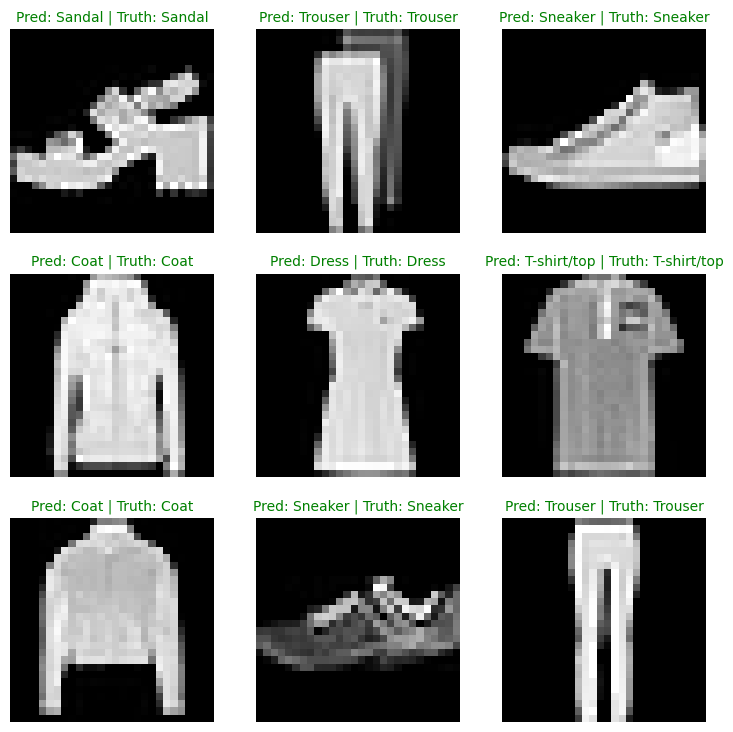

In [63]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[predictions[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)

let's make a **confusion matrix**
1. make predictions
2. make confusion matrix (`torchmetrics.ConfusionMatrix`)
3. plot it (`mlxtend.plotting.plot_confusion_matrix()`)

In [78]:
y_preds = []
model_v2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='predicted'):
        # X.shape is [32, 1, 28, 28]
        X, y = X.to(device), y.to(device)
        y_logit = model_v2(X)
        # y_logit shape is [32, 10]
        y_proba = torch.softmax(y_logit, dim=1)
        # y_proba shape is [32, 10]
        y_pred = y_proba.argmax(dim=1)
        # shape is [32]
        y_preds.append(y_pred.cpu())

predicted:   0%|          | 0/313 [00:00<?, ?it/s]

In [79]:
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor.shape
# shape should be [number_of_objects]

torch.Size([10000])

In [80]:
accuracy_metric(y_pred_tensor, test_data.targets)

tensor(0.8854)

version of mlxtend is 0.21.0


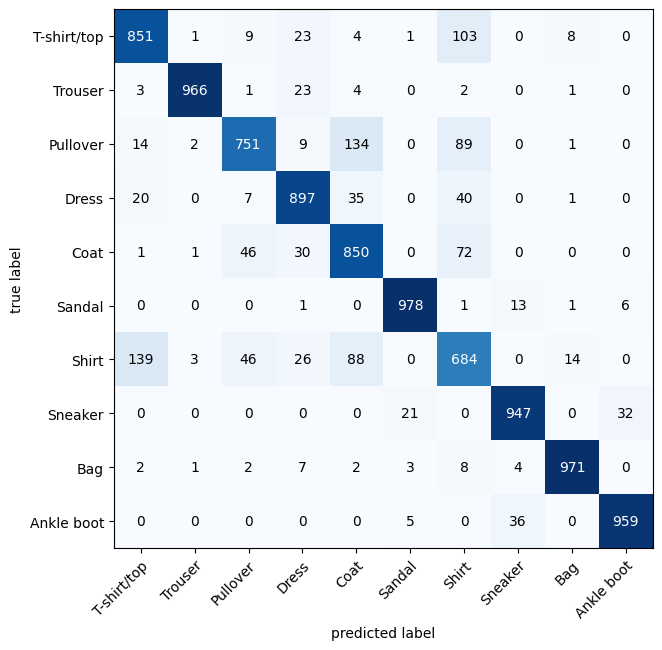

In [81]:
print('version of mlxtend is', mlxtend.__version__)

# setup confusion matrix
confmat = ConfusionMatrix(num_classes=10)
confmat_results = confmat(preds=y_pred_tensor,
                          target=test_data.targets)

# plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_results.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

# 8. Save and load model

In [86]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True) # if models dir already exists
MODEL_NAME = '03_computer_vision_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'Saving model to {MODEL_SAVE_PATH}')
torch.save(obj=model_v2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to models/03_computer_vision_model.pth


In [87]:
new_model = FashionModelV2(input_shape=1,
                           output_shape=10,
                           hidden_units=10)
new_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


y_preds = []
new_model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='predicted'):
        # X.shape is [32, 1, 28, 28]
        X, y = X.to(device), y.to(device)
        y_logit = new_model(X)
        # y_logit shape is [32, 10]
        y_proba = torch.softmax(y_logit, dim=1)
        # y_proba shape is [32, 10]
        y_pred = y_proba.argmax(dim=1)
        # shape is [32]
        y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)
accuracy_metric(y_pred_tensor, test_data.targets)

predicted:   0%|          | 0/313 [00:00<?, ?it/s]

tensor(0.8854)

In [88]:
new_model_results = eval_model(model=new_model,
                               data_loader=test_dataloader,
                               loss_fn=loss_fn,
                               score_fn=accuracy_metric)
new_model_results

{'model_name': 'FashionModelV2',
 'model_loss': 0.3158703148365021,
 'model_score': 0.8855830430984497}

In [89]:
# compare two tensors
torch.isclose(torch.tensor(results_v2['model_loss']),
              torch.tensor(new_model_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)